# **RECAP MODELING PROCESS**

**CONTENT :**
1. Load Data
2. Prepare Data
3. Built Preprocessing
4. Built Model (KNN, LogReg, DT)
5. Best Model (Based On Accuracy)

In [1]:
# Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [3]:
# Load Data

data = pd.read_csv('adult.csv')
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
# Check Data Info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [5]:
# Check Missing Value

data.isna().sum()/len(data)*100

age               0.0
workclass         0.0
fnlwgt            0.0
education         0.0
education.num     0.0
marital.status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital.gain      0.0
capital.loss      0.0
hours.per.week    0.0
native.country    0.0
income            0.0
dtype: float64

In [11]:
# Data Desc

listItem = []
for col in data.columns :
    listItem.append(
        [col, 
         data[col].dtype,
         data[col].isna().sum(),
         round(data[col].isna().sum()/len(data)*100,2),
         data[col].nunique(),
         list(data[col].drop_duplicates().sample(2).values)]
    )

desc_data = pd.DataFrame(data = listItem,
                         columns = ['Column','Data Type', 'Missing Value',
                                    'Pct Missing Value', 'Num Unique', 'Unique Sample'])

desc_data

,Column,Data Type,Missing Value,Pct Missing Value,Num Unique,Unique Sample
0,age,int64,0,0.0,73,"[33, 84]"
1,workclass,object,0,0.0,9,"[?, Self-emp-inc]"
2,fnlwgt,int64,0,0.0,21648,"[164190, 188982]"
3,education,object,0,0.0,16,"[5th-6th, 1st-4th]"
4,education.num,int64,0,0.0,16,"[6, 16]"
5,marital.status,object,0,0.0,7,"[Widowed, Married-spouse-absent]"
6,occupation,object,0,0.0,15,"[Other-service, Handlers-cleaners]"
7,relationship,object,0,0.0,6,"[Not-in-family, Husband]"
8,race,object,0,0.0,5,"[Other, Amer-Indian-Eskimo]"
9,sex,object,0,0.0,2,"[Male, Female]"


**SKEMA PREPROCESSING**

1. Missing Value : Fill Value 'NC'
2. One Hot Encoding : Relationship, Race, Sex
3. Binary Encoding : Workclass, Marital Status, Occupation, Native Country
4. Ordinal Encoding : Education (Already Encoded)
5. No Treatement : Size
6. Take Out : fnlwgt

In [12]:
# Change '?' To Missing Value

data.replace('?', np.nan, inplace=True)
data.isna().sum()/len(data)*100

age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.790486
income            0.000000
dtype: float64

In [24]:
# Skema Preprocessing

BE_Pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='NC')),
    ('BE', ce.BinaryEncoder())
])

transformer = ColumnTransformer([
    ('OHE', OneHotEncoder(drop='first'), ['relationship', 'race', 'sex']),
    ('Binary Enc', BE_Pipeline, ['workclass', 'marital.status', 'occupation', 'native.country'])
], remainder='passthrough')

In [16]:
# Data Spliting

X = data.drop(columns=['fnlwgt', 'education', 'income'])
y = np.where(data['income'] == '>50K', 1, 0)


xtrain, xtest, ytrain, ytest = train_test_split(
    X,
    y,
    stratify=y,
    random_state=100,
    test_size=0.2
)

In [51]:
# Transforming Data

X_train_prepros = transformer.fit_transform(xtrain)
X_test_prepros = transformer.transform(xtest)

X_train_prepros = pd.DataFrame(X_train_prepros)
X_test_prepros = pd.DataFrame(X_test_prepros)

feature = list(transformer.transformers_[0][1].get_feature_names_out()) + transformer.transformers_[1][1]['BE'].get_feature_names_out() + ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
X_train_prepros.columns = feature
X_test_prepros.columns = feature

X_train_prepros.head()

,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male,...,3_1,3_2,3_3,3_4,3_5,age,education.num,capital.gain,capital.loss,hours.per.week
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,23.0,13.0,0.0,0.0,15.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,36.0,10.0,7298.0,0.0,40.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,33.0,9.0,0.0,0.0,40.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,51.0,13.0,0.0,1902.0,40.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,33.0,6.0,0.0,0.0,40.0


In [53]:
# Get Best Model

logreg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=10)
tree = DecisionTreeClassifier(max_depth=10) 

acc = []

for model in [logreg, knn, tree] :
    model.fit(X_train_prepros, ytrain)
    y_pred = model.predict(X_test_prepros)
    acc.append(accuracy_score(ytest, y_pred))

pd.DataFrame({
    'Model' : ['Logistic Regression', 'KNN', 'Decission Tree'],
    'Accuracy Score' : acc
}).sort_values('Accuracy Score', ascending=False)

,Model,Accuracy Score
2,Decission Tree,0.855059
1,KNN,0.851221
0,Logistic Regression,0.839552


In [57]:
model.predict(X_test_prepros)

array([0, 0, 0, ..., 0, 0, 0])

In [56]:
model.predict_proba(X_test_prepros)

array([[9.99420290e-01, 5.79710145e-04],
       [5.19926426e-01, 4.80073574e-01],
       [5.19926426e-01, 4.80073574e-01],
       ...,
       [7.72727273e-01, 2.27272727e-01],
       [9.99420290e-01, 5.79710145e-04],
       [9.69696970e-01, 3.03030303e-02]])

In [58]:
model.feature_importances_

array([3.53663249e-03, 0.00000000e+00, 0.00000000e+00, 3.83805573e-04,
       7.03551797e-03, 1.25161031e-04, 5.51597592e-04, 2.71466828e-04,
       0.00000000e+00, 2.76113234e-03, 0.00000000e+00, 1.81348482e-03,
       2.31090270e-03, 1.34205930e-03, 4.25886897e-03, 3.27970452e-01,
       1.66169157e-02, 9.67783264e-03, 4.79536605e-03, 2.98325720e-03,
       3.64294781e-03, 6.20853788e-04, 3.68474816e-04, 1.82498950e-04,
       5.98994368e-04, 5.60302287e-04, 1.37162906e-03, 5.27838670e-02,
       2.36639891e-01, 1.98881544e-01, 7.21766035e-02, 4.57379410e-02])

In [60]:
# Feature Importance

imp_table = pd.DataFrame({
    'Importance Value' : model.feature_importances_
}, index=feature).sort_values('Importance Value')

imp_table

,Importance Value
relationship_Other-relative,0.000000
relationship_Own-child,0.000000
race_White,0.000000
0_0,0.000000
race_Asian-Pac-Islander,0.000125
3_2,0.000182
race_Other,0.000271
3_1,0.000368
relationship_Unmarried,0.000384
race_Black,0.000552


<AxesSubplot:>

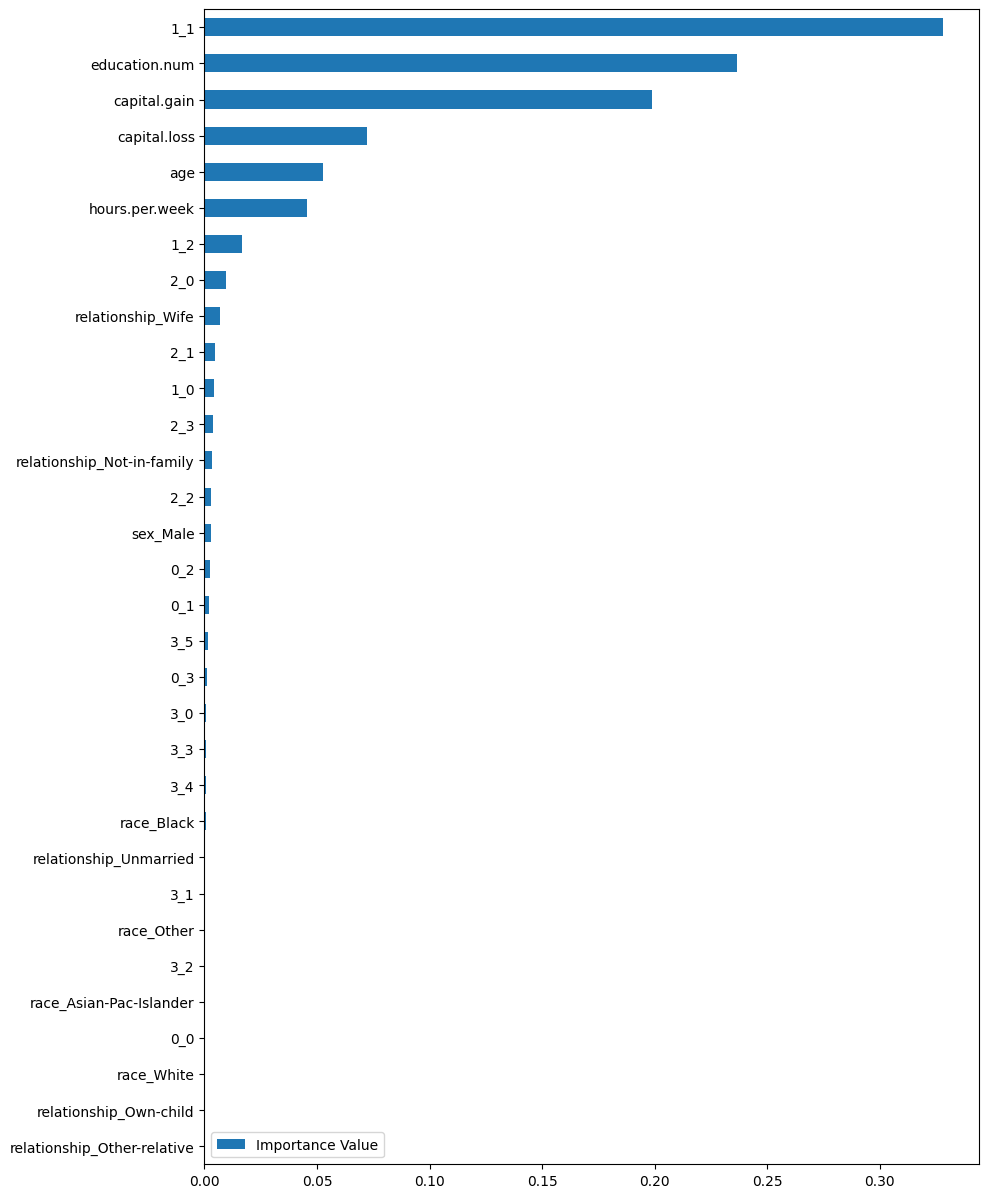

In [62]:
imp_table.plot(kind='barh', figsize=(10,15))